In [11]:
# data
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

words = open('./data/names.txt', 'r').read().splitlines()
v = sorted(list(set(''.join(words))))
encode = { c:i+1 for i,c in enumerate(v) }
encode['.'] = 0
decode = { i:c for c,i in encode.items() }

context_length = 3
def gen_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * context_length;
        for c in w + '.':
            X.append(context)
            Y.append(encode[c])
            # print(''.join(decode[i] for i in context), '-->', decode[encode[c]])
            context = context[1:] + [encode[c]]
    X, Y = torch.tensor(X), torch.tensor(Y) # X:(N,C) Y:(N)
    return X, Y

random.seed(42)
random.shuffle(words)
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
Xtr, Ytr = gen_dataset(words[:n1])
Xdev, Ydev = gen_dataset(words[n1:n2])
Xte, Yte = gen_dataset(words[n2:])

In [12]:
# model
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # bufs
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch var
        else: # inference
            xmean = self.running_mean
            xvar = self.running_var
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


# kaiming init: https://arxiv.org/pdf/1502.01852
# C = torch.randn((V,n_embd), generator=g)
# W1, b1 = torch.randn((clXne,n_hid), generator=g) * (5/3)/(clXne**0.5), torch.randn(n_hid, generator=g) * 0.01
# W2, b2 = torch.randn((n_hid,V), generator=g) * 0.01, torch.randn(V, generator=g) * 0
# bngain, bnbias = torch.ones((1, n_hid)), torch.zeros((1, n_hid))
# params = [C, W1, b1, W2, b2, bngain, bnbias]

g = torch.Generator().manual_seed(2147483647)
V, N, N_mini = len(encode.items()), Xtr.shape[0], 32
n_embd, n_hid = 10, 200
print("N=", N, "N_mini=", N_mini)

C = torch.randn((V,n_embd), generator=g)
layers = [
    Linear(context_length * n_embd, n_hid), Tanh(),
    Linear(n_hid, n_hid), Tanh(),
    Linear(n_hid, n_hid), Tanh(),
    Linear(n_hid, n_hid), Tanh(),
    Linear(n_hid, n_hid), Tanh(),
    Linear(n_hid, V),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # reduce confidence of last layer
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 5/3

params = [C] + [p for l in layers for p in l.parameters()]
print("params", sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

N= 182625 N_mini= 32
params 172697


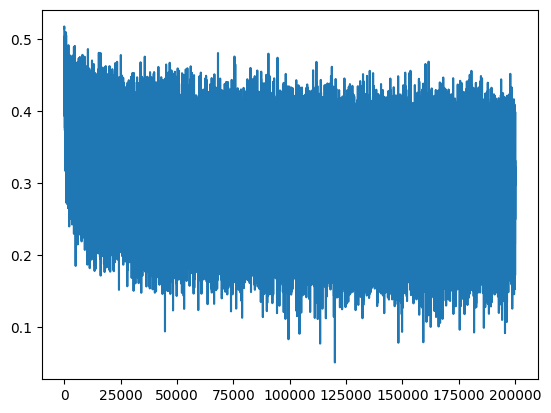

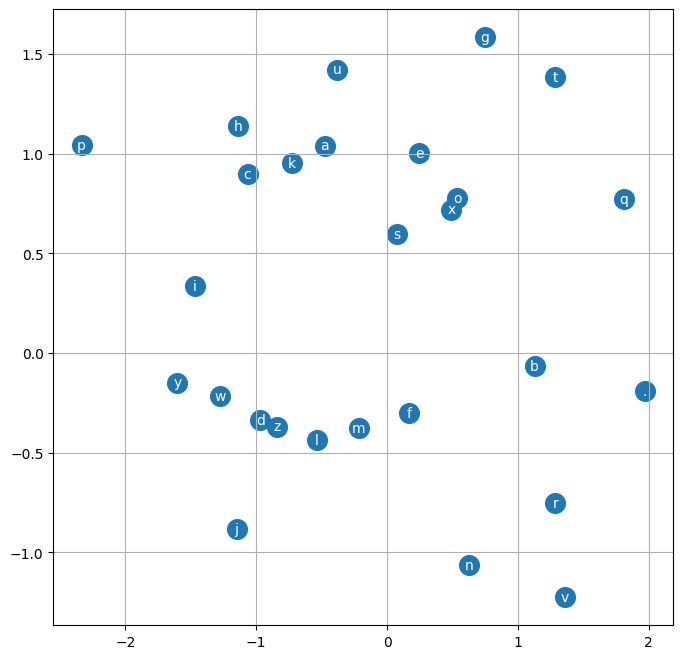

In [14]:
# training
losses = [] 
steps = []
for i in range(200000):
    # -forward
    ix_mini = torch.randint(0, N, (N_mini,))
    X_mini, Y_mini = Xtr[ix_mini], Ytr[ix_mini]

    # h1preact =  embcat @ W1 + b1
    # h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
    # h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
    # logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)

    embcat = C[X_mini].view(-1,context_length * n_embd)
    x = embcat
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, Y_mini) # fused kernels, numerical stability
    # print(loss.item())

    # -backward
    for l in layers:
        l.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()
    # -update
    for p in params:
        p.data += -0.01 * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

plt.plot(steps, losses)

# embcat = C[Xtr].view(-1,context_length * n_embd)
# h1preact =  embcat @ W1 + b1
# h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
# h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
# logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)
# loss = F.cross_entropy(logits, Ytr) # fused kernels, numerical stability
# print("loss_train", loss.item())

# embcat = C[Xdev].view(-1,context_length * n_embd)
# h1preact =  embcat @ W1 + b1
# h1preact = bngain * (h1preact - h1preact.mean(0, keepdim=True)) / h1preact.std(0, keepdim=True) + bnbias
# h1 = torch.tanh(h1preact) # (-1=32,3,2)->(N:32,C*E:6) @ (C*E:6,100) = (32,100)
# logits = (h1 @ W2) + b2 # R (32,100) @ (100,27) + (1,27) = (32,27)
# loss = F.cross_entropy(logits, Ydev) # fused kernels, numerical stability
# print("loss_val", loss.item())

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), decode[i], ha="center", va="center", color="white")
plt.grid('minor')

In [16]:
# generalization
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.975150465965271
val 2.0946433544158936


In [17]:
# inference
i_terminal = 0
for _ in range(20):
    output = []
    context = [0] * context_length
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        for l in layers:
          x = l(x)
        logits = x
        y_hat = F.softmax(logits, dim=1)

        i = torch.multinomial(y_hat, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [i]
        output.append(decode[i])
        if i == i_terminal:
            break
    print(''.join(output))

vithm.
spadtic.
ziah.
zan.
aker.
dha.
nasiiah.
lee.
torretani.
jossyaucellen.
boy.
merykeertersamuia.
arvestefan.
grayla.
brahi.
nyiah.
lydalekahelen.
eyreefer.
jiyah.
kalyn.
